# Propensity Score Matching and Balance Measures with CausalML


In [1]:
# Note: Some of the content in this notebook is derived from work done by Mike Yung

In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor
import warnings

from causalml.propensity import ElasticNetPropensityModel
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.inference.meta import BaseXRegressor, BaseDRRegressor
from causalml.inference.iv import BaseDRIVRegressor
from causalml.dataset import synthetic_data
from causalml.metrics import *

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

%matplotlib inline

## Synthetic Data Generation

In [41]:
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=10000, p=8, sigma=1.0)

In [42]:
y # outcome variable
# X # independent variables
# treatment # w, treatment flag
# tau # individual treatment effect
# b # expected outcome
# e # treatment propensity

array([ 0.72848693,  2.7929246 ,  0.7692917 , ..., -0.19900013,
        5.26583942,  3.31271324])

# Create base DF

In [43]:
TREATMENT_COL = 'W'
PROPENSITY_COL = 'pihat'
OUTCOME_COL = 'y'

In [44]:
df = pd.DataFrame(X)
df = df.add_prefix("X")
df[TREATMENT_COL] = treatment
df[PROPENSITY_COL] = e
df

,X0,X1,X2,X3,X4,X5,X6,X7,W,pihat
0,0.416132,0.358418,0.966980,0.186682,0.182749,0.604577,0.911903,0.693163,0,0.451607
1,0.833502,0.380733,0.655064,0.692909,0.847590,0.647858,0.137125,0.451944,0,0.839824
2,0.121966,0.889751,0.288749,0.677978,0.603034,0.547576,0.504914,0.853194,0,0.334357
3,0.547278,0.819728,0.907954,0.888561,0.392913,0.980219,0.878166,0.246346,1,0.900000
4,0.562207,0.405680,0.639606,0.966251,0.825527,0.004006,0.812604,0.930783,0,0.656767
...,...,...,...,...,...,...,...,...,...,...
9995,0.312988,0.471860,0.381009,0.142346,0.407910,0.879259,0.009456,0.674400,0,0.447502
9996,0.498376,0.245831,0.848145,0.715382,0.959248,0.146230,0.826609,0.371213,1,0.375464
9997,0.378321,0.515290,0.717094,0.554089,0.517513,0.678326,0.952068,0.982959,1,0.574864
9998,0.421745,0.754070,0.024432,0.566753,0.825262,0.427378,0.231659,0.648586,1,0.840988


# Display balance pre/post weighting by inverse probability of treatment (IPTW)

In [45]:
from causalml.metrics.visualize import *

In [46]:
covariates = [col for col in df if col.startswith('X')]
covariates

['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7']

The `plot_ps_diagnostics` function illustrates pre/post weighting by inverse probability of treatment.

Figure(640x480)


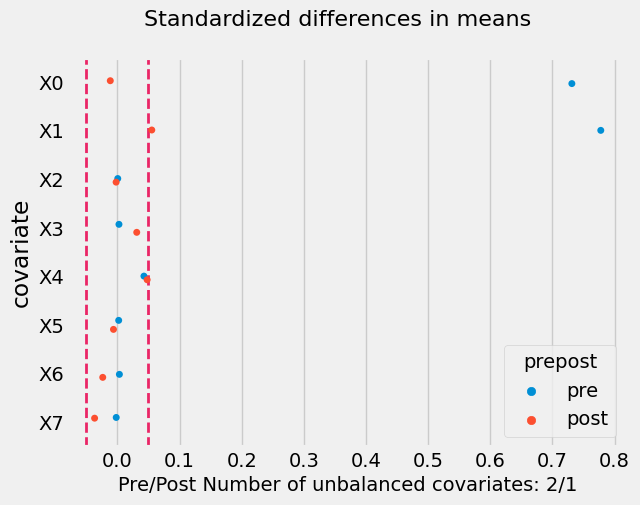

In [47]:
print(plot_ps_diagnostics(df, covariate_col=covariates, treatment_col=TREATMENT_COL, p_col=PROPENSITY_COL, bal_tol=0.05))

We can also use the `create_table_one` function to view means and standard deviations, in parentheses, of the Control and Treatment groups, as well as the standardized mean differences between the two groups.  The SMD values align with the `pre` values in `plot_ps_diagnostics`.

In [48]:
create_table_one(data=df, treatment_col=TREATMENT_COL, features=covariates)

,Control,Treatment,SMD
Variable,,,
n,4722,5278,
X0,0.40 (0.29),0.60 (0.25),0.7311
X1,0.39 (0.29),0.60 (0.25),0.7776
X2,0.50 (0.29),0.50 (0.29),0.0006
X3,0.50 (0.29),0.51 (0.29),0.0025
X4,0.50 (0.29),0.51 (0.29),0.0427
X5,0.50 (0.29),0.50 (0.29),0.002
X6,0.50 (0.28),0.50 (0.29),0.0032
X7,0.50 (0.29),0.50 (0.29),-0.0019


We can see that for this synthetic data, the X0 and X1 variables are obviously not balanced.  We can also verify this by looking at the histograms.

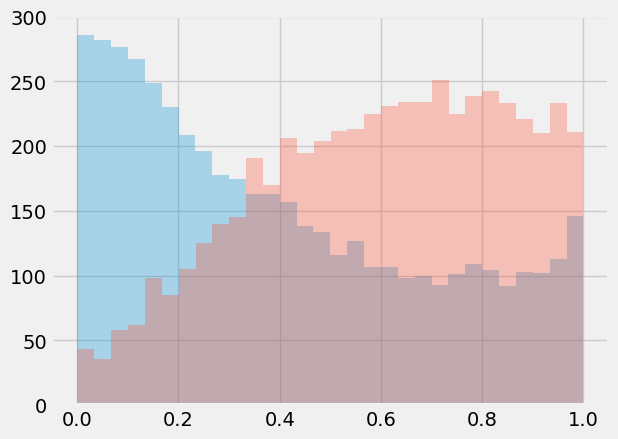

In [49]:
_ = df.groupby(TREATMENT_COL).apply(lambda x: plt.hist(x['X0'], alpha=0.3, bins=30))

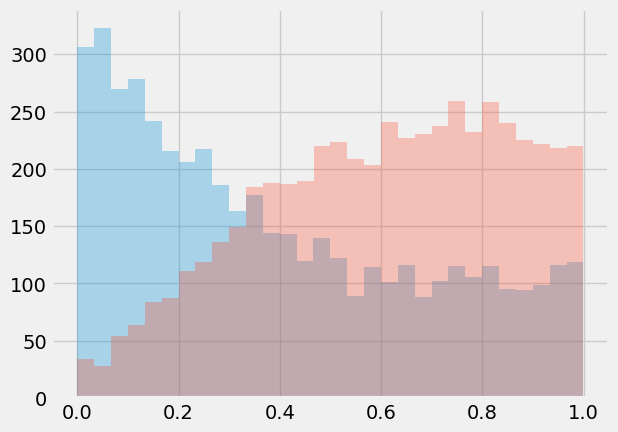

In [50]:
_ = df.groupby(TREATMENT_COL).apply(lambda x: plt.hist(x['X1'], alpha=0.3, bins=30))

From `plot_ps_diagnostics`, `create_table_one`, and via the above histograms, we see that X0 and X1 are clearly unbalanced.

Note that `plot_ps_diagnostics` function shows that we can improve balance through IPTW.  However, we will illustrate below how using matching can also improve balance independent of IPTW.

# Matching

Now let's apply matching to see if we can reduce the SMDs.

The `NearestNeighborMatch` class expects a Pandas DataFrame when `match()` is called, so first we package the existing features data `X` into a dataframe. 

Next, we instantiate `NearestNeighborMatch` and define `score_cols` to specify the matcher to match on just the propensity variable.

In [60]:
matcher = NearestNeighborMatch()
score_cols = [PROPENSITY_COL]
df_matched = matcher.match(data=df, treatment_col=TREATMENT_COL, score_cols=score_cols)
create_table_one(data=df_matched, treatment_col=TREATMENT_COL, features=covariates)

,Control,Treatment,SMD
Variable,,,
n,2274,2274,
X0,0.50 (0.28),0.50 (0.28),0.0143
X1,0.50 (0.27),0.51 (0.28),0.0372
X2,0.50 (0.29),0.50 (0.29),-0.0255
X3,0.50 (0.29),0.51 (0.29),0.0317
X4,0.50 (0.29),0.51 (0.29),0.0331
X5,0.49 (0.29),0.49 (0.29),-0.0066
X6,0.50 (0.29),0.50 (0.29),0.0075
X7,0.51 (0.29),0.50 (0.28),-0.0112


`df_matched` contains the matched subset:

In [61]:
df_matched.shape

(4548, 10)

SMD is the standardized mean difference of the variable between the two classes (Control and Treatment). An SMD value of < 0.1 is typically considered a good balance. Using the synthetically generated data, we achieve good balance for all covariates when matching on the propensity score alone. However, sometimes you may find that matching purely on the propensity variable does not achieve good balance for all the covariates you would like to control for.

### An aside: Match Optimization

In [62]:
dfmo = df.copy()

In [63]:
dfmo['noise'] = dfmo.apply(lambda x: np.random.randn()-0.3 if x[TREATMENT_COL]==1 else np.random.randn(), axis=1)

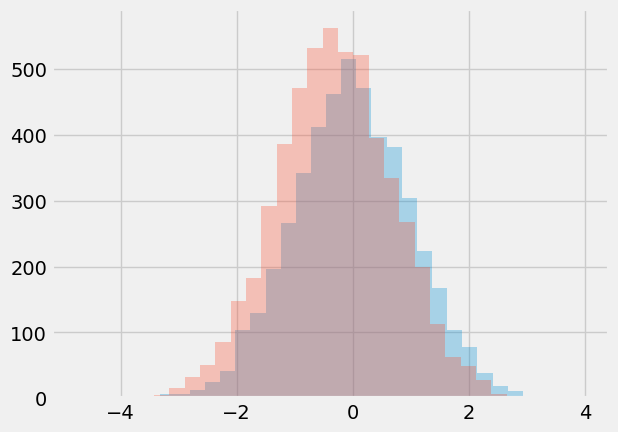

In [64]:
_ = dfmo.groupby(TREATMENT_COL).apply(lambda x: plt.hist(x['noise'], alpha=0.3, bins=30))

Let's redo the propensity scoring + matching process and take a look at the results.

In [65]:
p_model = ElasticNetPropensityModel()
p_hat = p_model.fit_predict(X=np.hstack((X, dfmo['noise'].values.reshape(-1,1))),
                            y=treatment)

dfmo_matched = matcher.match(data=dfmo, treatment_col=TREATMENT_COL, score_cols=score_cols)

# define your own covariates to check matched balance
covariates_to_check = [col for col in dfmo_matched if col != TREATMENT_COL and col != OUTCOME_COL]

create_table_one(data=dfmo_matched, treatment_col=TREATMENT_COL, features=covariates_to_check)

,Control,Treatment,SMD
Variable,,,
n,2274,2274,
X0,0.49 (0.28),0.50 (0.28),0.0055
X1,0.50 (0.27),0.51 (0.28),0.0387
X2,0.51 (0.29),0.50 (0.29),-0.0273
X3,0.50 (0.29),0.51 (0.29),0.0319
X4,0.50 (0.29),0.50 (0.29),0.002
X5,0.49 (0.29),0.49 (0.29),-0.0025
X6,0.50 (0.29),0.50 (0.29),-0.0024
X7,0.50 (0.29),0.51 (0.28),0.0042


Now, the noise variable (which inherently has an imbalanced distribution between classes) does not achieve an acceptable SMD score. `causalml` has a built-in `MatchOptimizer` that will search for the best combinations of parameters to achieve good balance across all variables (refer to docs for more detail).

In [66]:
if 'noise' not in covariates_to_check:
    covariates_to_check.append('noise')

opt = MatchOptimizer(treatment_col=TREATMENT_COL,
                     ps_col=PROPENSITY_COL,
                     matching_covariates=covariates_to_check,
                     caliper_range=(0.01,1))
dfmo_matched = opt.search_best_match(dfmo)

In [68]:
create_table_one(data=dfmo_matched, treatment_col=TREATMENT_COL, features=covariates_to_check)

,Control,Treatment,SMD
Variable,,,
n,5278,5278,
X0,0.61 (0.25),0.60 (0.25),-0.0363
X1,0.60 (0.25),0.60 (0.25),0.0226
X2,0.50 (0.29),0.50 (0.29),0.0014
X3,0.50 (0.28),0.51 (0.29),0.027
X4,0.48 (0.29),0.51 (0.29),0.0863
X5,0.50 (0.28),0.50 (0.29),-0.0061
X6,0.52 (0.28),0.50 (0.29),-0.0473
X7,0.52 (0.29),0.50 (0.29),-0.0675


Balance looks better now.

For the remaining sections, we will not use the introduced noise variable.

In [69]:
dfmo_matched.shape

(10556, 11)

Note that df_matched has more rows than the original dataframe.  This is because the original dataframe has more treatment subjects than control subjects.

In [70]:
sum(dfmo["W"]==1)

5278

Each treatment subject is matched to a control, with the possibility that some treatment subjects are not matched due to the caliper constraint.

We will now return to matching with our original, "non-noised" dataframe.

# Illustrate matching improves covariate balance

Note that PSM is redundant from a theoretical point of view, but some users report having had good results in practice, as stated in [this issue](https://github.com/uber/causalml/issues/430):

> Propensity score matching is not required for estimating ATEs with meta-learners so long as the covariates that you use block any back-door paths between the treatment and outcome.

> Then again, if the covariates don't block all back-door paths between the treatment and outcome, the matching step will not achieve its intended goal of balancing confounders between treatment and control observations.

> Consequently, using matching with meta-learners is redundant from a theoretical point of view. That said, my understanding is that some users have had good results in practice when combining matching with meta-learners.

We explore if using PSM improves results for this test case and illustrate that in agreement with the theoretical prediction, it does not.  Nevertheless, understanding balance properties can be helpful for diagnosing issues related to covariate distributions.

We check the matched dataframe's X0 and X1 variables for balance and the histograms seem better aligned.

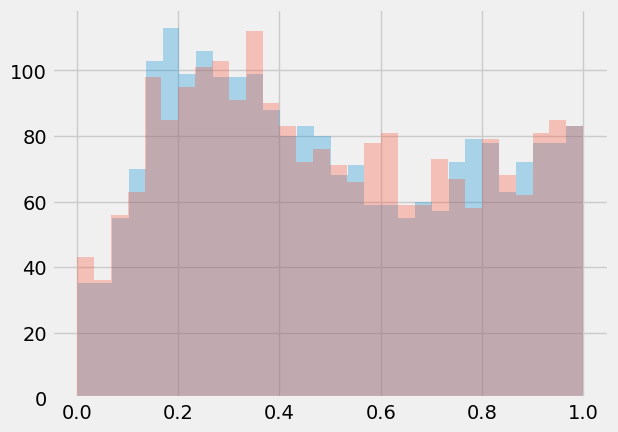

In [71]:
_ = df_matched.groupby(TREATMENT_COL).apply(lambda x: plt.hist(x['X0'], alpha=0.3, bins=30))

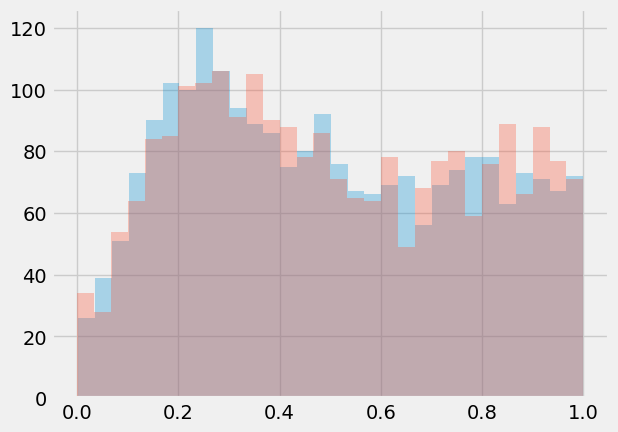

In [72]:
_ = df_matched.groupby(TREATMENT_COL).apply(lambda x: plt.hist(x['X1'], alpha=0.3, bins=30))

Finally, the distribution according to the propensity score also looks balanced.

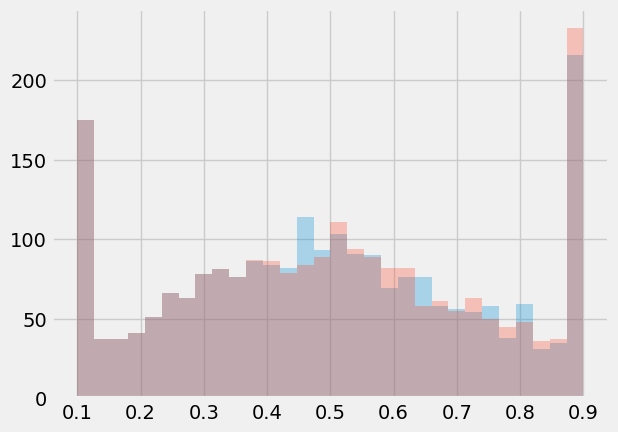

In [73]:
_ = df_matched.groupby(TREATMENT_COL).apply(lambda x: plt.hist(x[PROPENSITY_COL], alpha=0.3, bins=30))

## Comparing DR Learner with X Learner

We use a flexible ML estimator to estimate the outcome model but a simple linear regression model to estimate the ITE, since the ITE estimate is often noisy and prone to overfit with a flexible estimator.

In [74]:
learner_x = BaseXRegressor(learner=XGBRegressor(), treatment_effect_learner=LinearRegression())
cate_x = learner_x.fit_predict(X=X, treatment=treatment, y=y)

In [75]:
learner_dr = BaseDRRegressor(learner=XGBRegressor(), treatment_effect_learner=LinearRegression())
cate_dr = learner_dr.fit_predict(X=X, treatment=treatment, y=y)

DR Learner outforms X Learner in this dataset. Even with built-in mechanism to counteract the unbalancedness between the treatment and control samples, X Learner still suffers from the regime where the treatment probability is close to 1 in this case.

Text(0.5, 1.0, 'DR Learner')

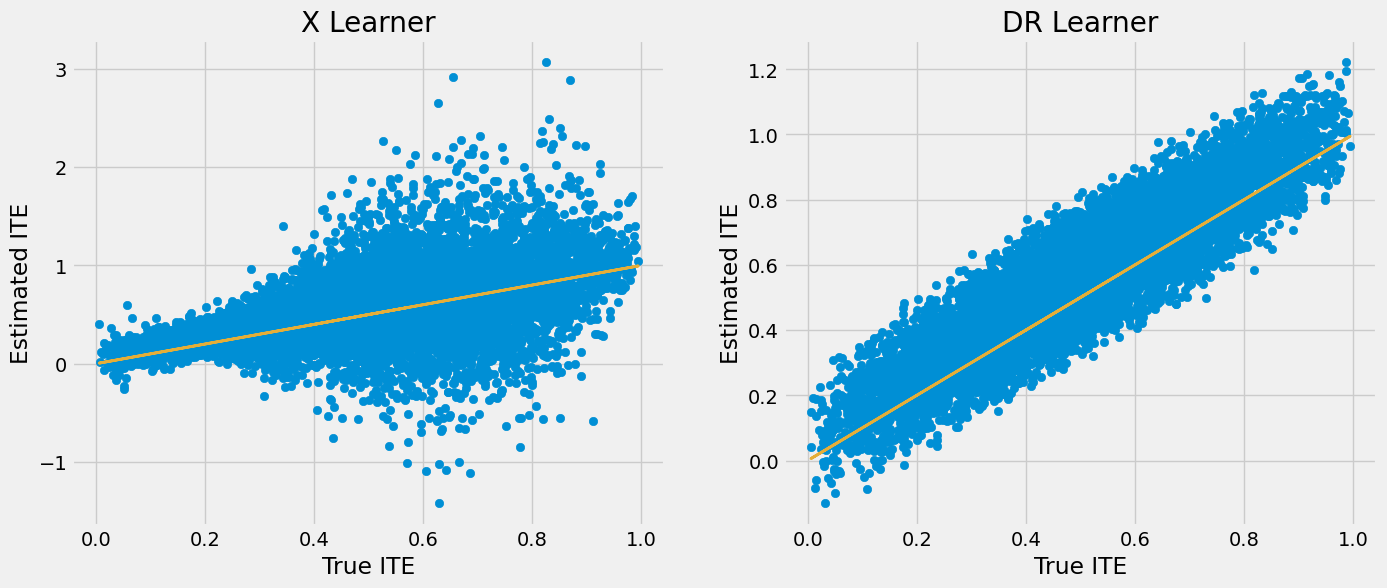

In [76]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].scatter(tau, cate_x)
ax[0].plot(tau, tau, color='C2', linewidth=2)
ax[0].set_xlabel('True ITE')
ax[0].set_ylabel('Estimated ITE')
ax[0].set_title('X Learner')
ax[1].scatter(tau, cate_dr)
ax[1].plot(tau, tau, color='C2', linewidth=2)
ax[1].set_xlabel('True ITE')
ax[1].set_ylabel('Estimated ITE')
ax[1].set_title('DR Learner')

# Re-run learner using matched samples

In [77]:
learner_x = BaseXRegressor(learner=XGBRegressor(), treatment_effect_learner=LinearRegression())
cate_x = learner_x.fit_predict(X=X[df_matched.index.astype(int)],
                               treatment=treatment[df_matched.index.astype(int)],
                               y=y[df_matched.index.astype(int)])

In [78]:
learner_dr = BaseDRRegressor(learner=XGBRegressor(), treatment_effect_learner=LinearRegression())
cate_dr = learner_dr.fit_predict(X=X[df_matched.index.astype(int)],
                               treatment=treatment[df_matched.index.astype(int)],
                               y=y[df_matched.index.astype(int)])

In [79]:
cate_x.shape

(4548, 1)

Text(0.5, 1.0, 'DR Learner')

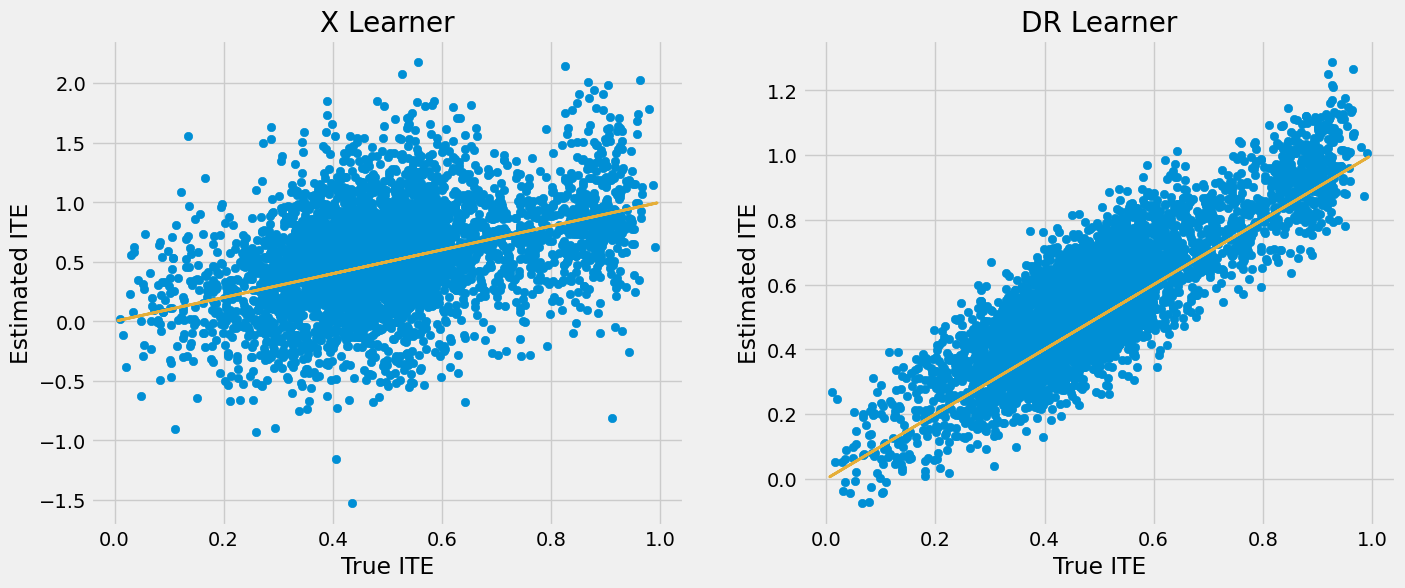

In [80]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].scatter(tau[df_matched.index.astype(int)], cate_x)
ax[0].plot(tau, tau, color='C2', linewidth=2)
ax[0].set_xlabel('True ITE')
ax[0].set_ylabel('Estimated ITE')
ax[0].set_title('X Learner')
ax[1].scatter(tau[df_matched.index.astype(int)], cate_dr)
ax[1].plot(tau, tau, color='C2', linewidth=2)
ax[1].set_xlabel('True ITE')
ax[1].set_ylabel('Estimated ITE')
ax[1].set_title('DR Learner')

# Summary

As we can see, the results using the full sample and with a propensity-score-matched subsample do not differ much.  There is perhaps less dispersion in the X Learner.  Nevertheless, it can be helpful to understand if there are extreme covariate imbalances in the data and this is done well by the distributional graphs and heuristics provided in Cobalt.